# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [9]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer

from ruzicka.test_metrics import nini, minmax, cosine

In [10]:
vecs = pd.read_csv("elegy_poetic.csv", index_col=0)
corpus = vecs[vecs["LEN"] >= 20].reset_index(drop=True)

In [11]:
test_corpus = corpus[corpus.Author != "ps-Ovid"].reset_index(drop=True)
test_corpus

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Ovid,Pont.,Pont. 4 12,0.120000,0.520000,0.720000,0.440000,0.240000,0.560000,0.920000,...,0.0,0.280000,0.040000,0.280000,1.000000,0.100000,3.073075,0.615696,50,0.000000
266,Ovid,Pont.,Pont. 4 13,0.160000,0.600000,0.680000,0.800000,0.280000,0.720000,0.920000,...,0.0,0.240000,0.080000,0.360000,0.880000,0.100000,5.954342,1.723439,50,0.775629
267,Ovid,Pont.,Pont. 4 14,0.129032,0.580645,0.548387,0.645161,0.096774,0.774194,0.903226,...,0.0,0.193548,0.032258,0.193548,0.903226,0.064516,3.314164,1.155196,62,0.591300
268,Ovid,Pont.,Pont. 4 15,0.095238,0.619048,0.666667,0.619048,0.285714,0.666667,0.714286,...,0.0,0.285714,0.095238,0.333333,0.952381,0.119048,3.695211,0.919168,42,0.425918


In [12]:
problems = corpus[corpus.Author == "ps-Ovid"].reset_index(drop=True)
problems

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,ps-Ovid,Nux,Nux,0.153846,0.450549,0.626374,0.626374,0.175824,0.604396,0.868132,...,0.0,0.197802,0.043956,0.285714,1.000000,0.082418,3.095360,0.524756,182,0.000000
1,ps-Ovid,Medicamina,Medicamina,0.280000,0.480000,0.520000,0.540000,0.180000,0.620000,0.880000,...,0.0,0.200000,0.040000,0.300000,1.000000,0.080000,4.901116,0.909967,100,0.000000
2,ps-Ovid,Consolatio,Consolatio 1,0.240506,0.481013,0.645570,0.531646,0.164557,0.582278,0.924051,...,0.0,0.088608,0.037975,0.278481,1.000000,0.246835,4.619877,0.606677,158,0.000000
3,ps-Ovid,Consolatio,Consolatio 2,0.253165,0.556962,0.556962,0.493671,0.240506,0.696203,0.810127,...,0.0,0.088608,0.025316,0.240506,1.000000,0.278481,3.608988,0.824542,158,0.000000
4,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.0,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.223589
5,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.0,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
6,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.0,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
7,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.0,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000
8,ps-Ovid,Ibis,Ibis 4,0.123596,0.438202,0.617978,0.528090,0.179775,0.685393,0.988764,...,0.0,0.258427,0.056180,0.213483,0.977528,0.033708,4.358413,0.791811,178,0.469227


In [13]:
zscale = StandardScaler(with_mean=False)
lenc = LabelEncoder()
X = np.array(zscale.fit_transform(test_corpus.drop(["Author", "Work", "Poem"], axis=1)))
y = np.array(lenc.fit_transform(test_corpus.Author))

In [14]:
probs_X = np.array(zscale.transform(problems.drop(["Author", "Work", "Poem"], axis=1)))

In [17]:
def bootstrap_imposters(
    test_vec: NDArray[float],
    X: NDArray[NDArray[float]],
    y: NDArray[int],
    cand_idx: int,
    n: int,
    pct: float,
    dist_fn: Callable[[NDArray[float], NDArray[float]], float],
    method: str = "random",
    rng: np.random.Generator = np.random.default_rng(),
) -> list[float]:
    # X at the row indices where y matches the condition
    candidates = X[(y == cand_idx).nonzero()]
    others = X[(y != cand_idx).nonzero()]
    differences: list[float] = []
    cand_samps: NDArray[float] = []
    other_samps: NDArray[float] = []
    if method == "random":
        # choose n random row indices with replacement, all columns. This will
        # still work if n > num_candidates because it will oversample.
        cand_samps = candidates[rng.choice(candidates.shape[0], n, replace=True), :]
        other_samps = others[rng.choice(others.shape[0], n, replace=True), :]

    # At each bootstrap iteration we choose a different feature subset
    for i in range(n):
        # from 1d vectors, choose (pct * width_of_X) random column indices (no
        # replacement)
        ridx = rng.choice(X.shape[1], int(X.shape[1] * pct), replace=False)

        # compare the test vector to one in-sample and one outsample (with
        # bootstrap columns), then record the difference of distances
        if method == "random":
            in_dist = dist_fn(test_vec[ridx], cand_samps[i][ridx])
            out_dist = dist_fn(test_vec[ridx], other_samps[i][ridx])
            differences.append(out_dist - in_dist)

        # compare the test vector to the closest in-sample and out-sample, then
        # record the difference of distances (like vanilla Kestemont GI)
        elif method == "closest":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            if len(in_dists) > len(out_dists):
                in_dists = rng.choice(in_dists, len(out_dists))
            differences.append(min(out_dists) - min(in_dists))

        # compare the test vector to the closest in-sample and out-sample, then
        # record the scaled difference of distances for the smallest 3 (like
        # Kestemont GI with Eder Boostrap Consensus Tree stye ranking)
        elif method == "ranked":
            in_dists = [
                dist_fn(test_vec[ridx], cand_samp[ridx]) for cand_samp in candidates
            ]
            out_dists = [
                dist_fn(test_vec[ridx], other_samp[ridx]) for other_samp in others
            ]
            if len(in_dists) > len(out_dists):
                in_dists = rng.choice(in_dists, len(out_dists))
            # faster than sorting and slicing
            top_in = heapq.nsmallest(3, in_dists)
            top_out = heapq.nsmallest(3, out_dists)
            d = 0
            for n in range(3):
                # smallest distances are unscaled, seccond is halved, etc
                d += (top_out[n] - top_in[n]) / (n + 1)
            differences.append(d)
        else:
            raise ValueError(
                f"Unsupported method {method}, valid are: random, closest, ranked"
            )
    return differences

In [18]:
problem_dict = dict(zip(problems.Poem, probs_X))

In [19]:
results = {}
for poem, vec in problem_dict.items():
    bs = bootstrap_imposters(
        vec,
        X,
        y,
        1,
        1000,
        0.33,
        minmax,
        "ranked",
        rng=np.random.default_rng(seed=42),
    )
    results[poem] = bs

<AxesSubplot:title={'center':'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

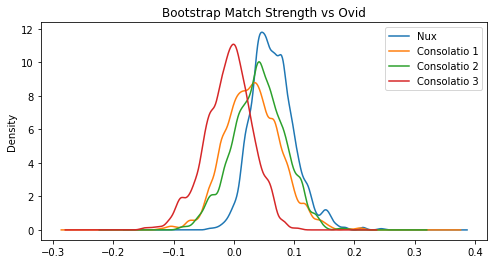

In [20]:
df = pd.DataFrame.from_dict(results)
df[
    df.columns[~(df.columns.str.startswith("Ibis") | df.columns.str.startswith("Medi"))]
].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8, 4),
    title="Bootstrap Match Strength vs Ovid",
)

<AxesSubplot:title={'center':'Bootstrap Match Strength vs Ovid'}, ylabel='Density'>

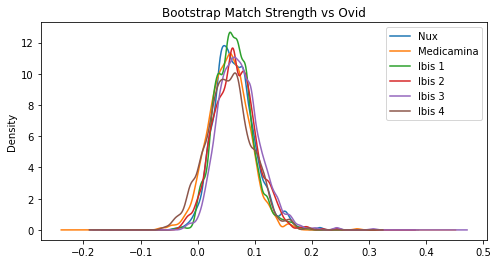

In [21]:
df[df.columns[~df.columns.str.startswith("Consolatio")]].plot(
    kind="kde",
    bw_method=0.15,
    figsize=(8, 4),
    title="Bootstrap Match Strength vs Ovid",
)

In [22]:
for poem, ary in results.items():
    print(f"{poem:<15}> Percent doubt: {sp.stats.percentileofscore(ary, 0):.2f}")

Nux            > Percent doubt: 2.00
Medicamina     > Percent doubt: 5.80
Consolatio 1   > Percent doubt: 25.10
Consolatio 2   > Percent doubt: 16.80
Consolatio 3   > Percent doubt: 56.70
Ibis 1         > Percent doubt: 1.10
Ibis 2         > Percent doubt: 3.00
Ibis 3         > Percent doubt: 0.90
Ibis 4         > Percent doubt: 8.90


In [23]:
%load_ext rpy2.ipython

In [24]:
dff = df.T

In [25]:
dff.reset_index(inplace=True)

In [35]:
tst = dff.melt(id_vars=["index"]).drop(["variable"], axis=1)

In [36]:
tst["cons"] = tst["index"].str.startswith("Cons")
tst

,index,value,cons
0,Nux,0.077127,False
1,Medicamina,0.046158,False
2,Consolatio 1,0.026897,True
3,Consolatio 2,0.069163,True
4,Consolatio 3,-0.046981,True
...,...,...,...
8995,Consolatio 3,-0.015772,True
8996,Ibis 1,0.029917,False
8997,Ibis 2,0.060926,False
8998,Ibis 3,0.064446,False


Picking joint bandwidth of 0.00855


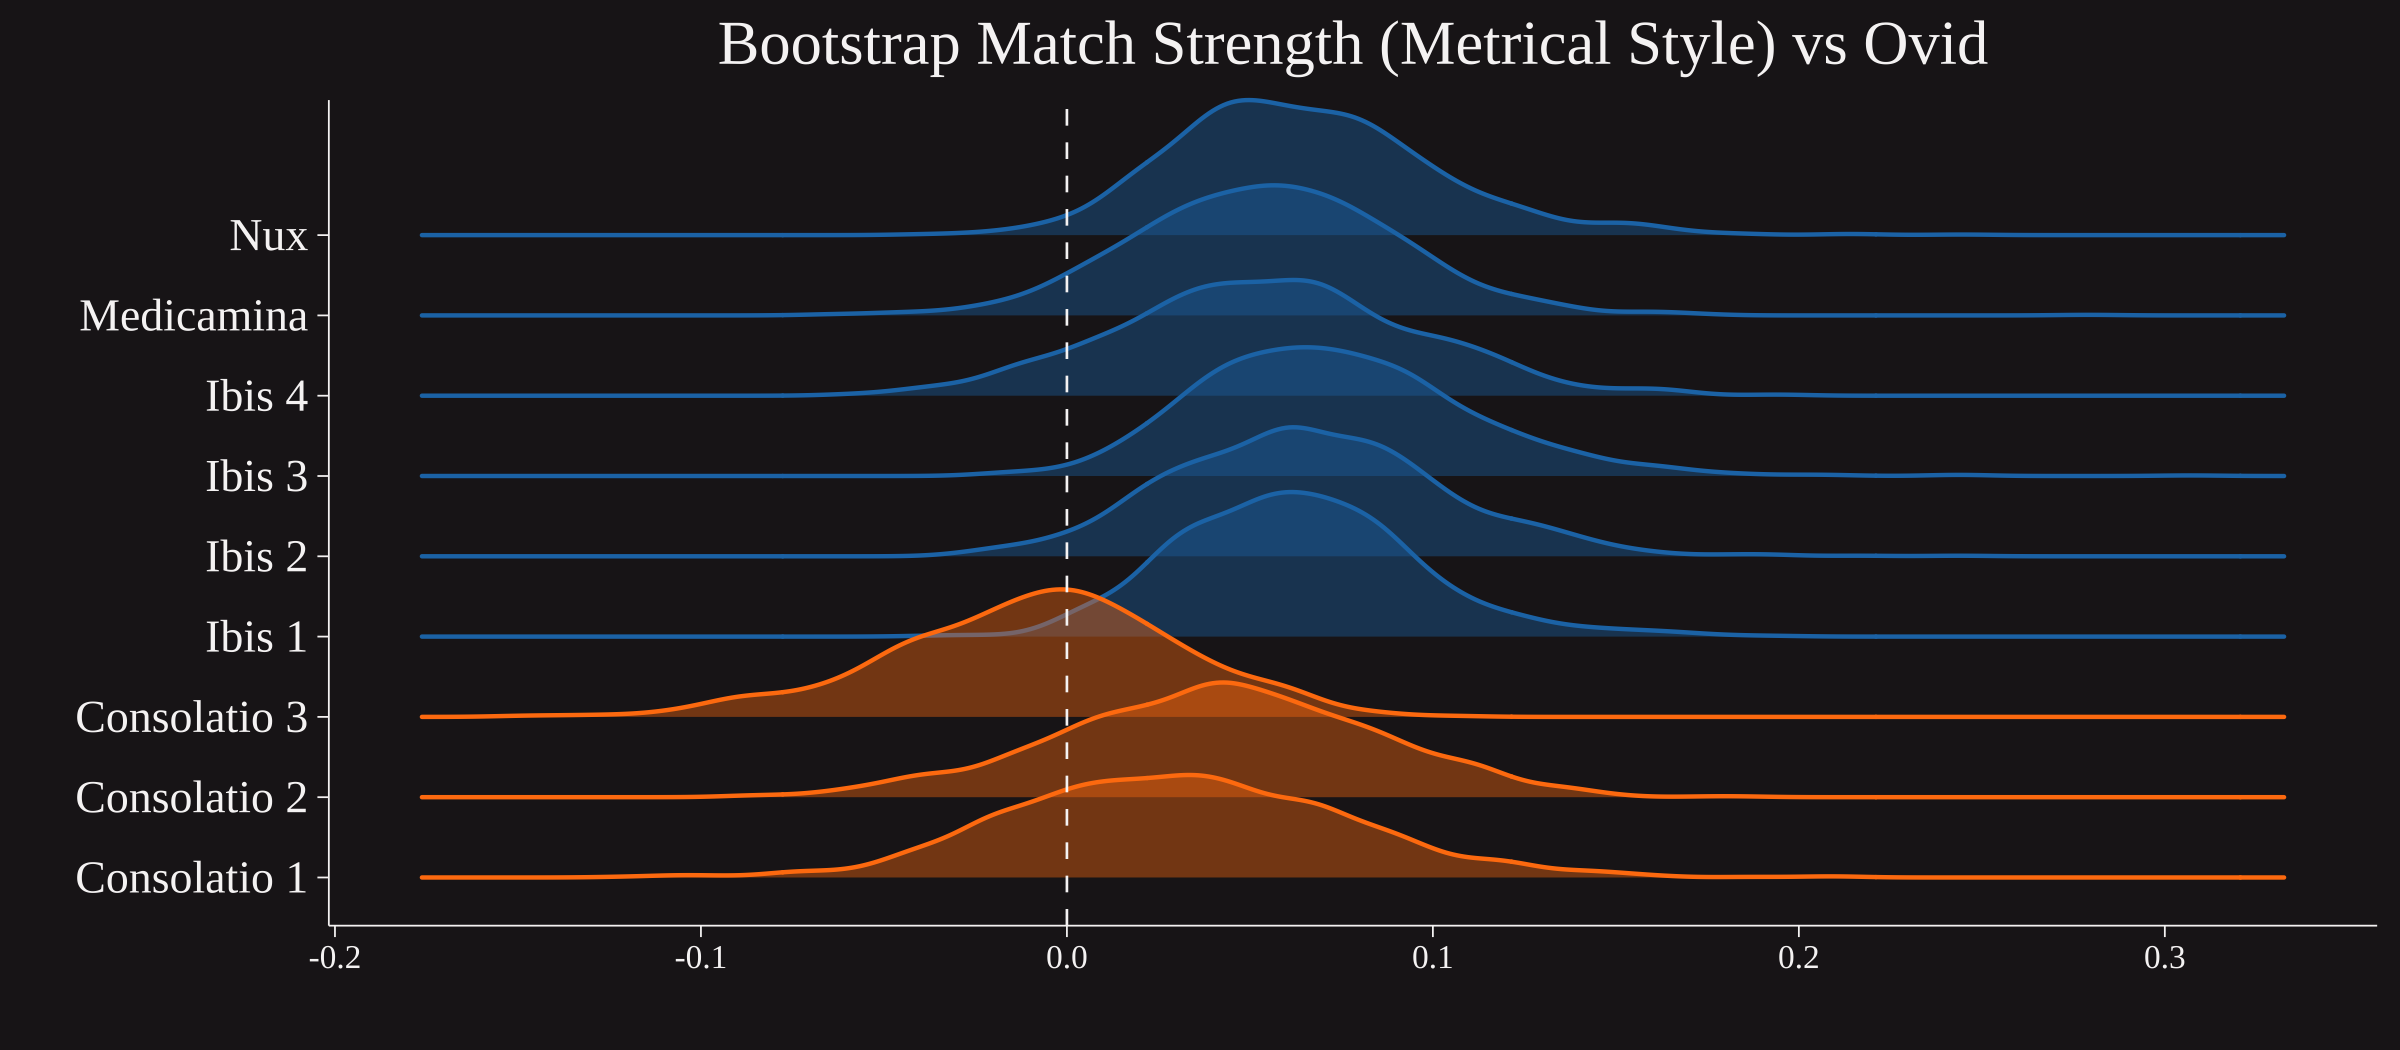

In [48]:
%%R -i tst -h 3.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Tinos", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"
bgcol <- '#1e1a1d'
fgcol <- '#f6f5f5'

ggplot(data=tst,aes(value,y=index,fill=cons,color=cons)) +
coord_cartesian(clip = "off") +
ggridges::stat_density_ridges(
    alpha = .4, size = 0.5,
) +
geom_vline(xintercept=0, colour=fgcol, linetype='dashed', size=0.3) +
#scale_y_discrete(limits=rev) +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Metrical Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(size=0.2,color=fgcol),
    axis.line.y=element_line(size=0.2,color=fgcol),
    axis.ticks.x=element_line(size=0.2,color=fgcol),
    axis.ticks.y=element_line(size=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../paper/figures/bootstrap_poetics.pdf"
# ggsave(fn, dpi=600, width=8, height=3.5, device=cairo_pdf)
